In [1]:
## Importing the required Packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime, date, time
import joblib
# to display all columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import figure
from pylab import rcParams

In [3]:
import copy
import statistics
import scipy.stats as stats
from scipy.stats import chi2_contingency, chisquare, lognorm, kstest, shapiro, normaltest, chi2, levene, ttest_ind, t
import scipy
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### loading pickled dataset

In [4]:
#### loading pickled dataset ####
df_train_fe = joblib.load("df_train_fe.pkl")
df_train_fe.shape

(54808, 90)

In [5]:
#### column names
df_train_fe.columns

Index(['index', 'employee_id', 'department', 'region', 'education', 'gender',
       'trainings_attended', 'age', 'previous_rating', 'service_yrs', 'kpi',
       'awarded', 'avg_training_score', 'promoted', 'region_rare',
       'education_nan', 'gender_le', 'previous_rating_nan', 'f_service_bins',
       'f_age_bins', 'ohe_dept_Analytics', 'ohe_dept_Finance', 'ohe_dept_HR',
       'ohe_dept_Legal', 'ohe_dept_Operations', 'ohe_dept_Procurement',
       'ohe_dept_R&D', 'ohe_dept_Sales & Marketing', 'ohe_dept_Technology',
       'f_dept_cnt', 'f_dept_train_score_mean', 'f_dept_train_score_median',
       'f_dept_train_score_min', 'f_dept_train_score_max',
       'f_dept_train_score_std', 'f_dept_age_mean', 'f_dept_age_median',
       'f_dept_age_min', 'f_dept_age_max', 'f_dept_age_std',
       'f_dept_service_mean', 'f_dept_service_median', 'f_dept_service_min',
       'f_dept_service_max', 'f_dept_service_std', 'f_region_cnt',
       'f_region_train_score_mean', 'f_region_train_score_me

#### FEATURE SELECTION 

In [6]:
# dropping few features 
df_train_fe = df_train_fe.drop(labels = ['department', 'region', 'education', 'gender', 'previous_rating', 'region_rare', 'education_nan'], axis = 1)
print(df_train_fe.shape)

(54808, 83)


In [7]:
# unique count values of each feature
df_features_unique_cnt = pd.DataFrame()
df_features_unique_cnt['unique_cnt'] = df_train_fe.nunique()
df_features_unique_cnt = df_features_unique_cnt.reset_index()
df_features_unique_cnt = df_features_unique_cnt.rename(columns = {'index' : 'features'})
df_features_unique_cnt.shape

(83, 2)

In [8]:
# drop constant features
constant_features = list(df_features_unique_cnt[df_features_unique_cnt['unique_cnt'] == 1]['features'])
print('Total constant features: ', len(constant_features))
df_train_fe = df_train_fe.drop(labels= constant_features, axis = 1)
df_train_fe.shape

Total constant features:  4


(54808, 79)

In [9]:
# drop quasi-constant columns 
for i in constant_features :
    df_features_unique_cnt = df_features_unique_cnt[df_features_unique_cnt['features'] != i ]
print(df_features_unique_cnt.shape)
print(len(constant_features))
print(df_train_fe.shape)

(79, 2)
4
(54808, 79)


In [10]:
#quasi_constant_features = list(df_features_unique_cnt[(df_features_unique_cnt['unique_cnt'] < 4)  & (df_features_unique_cnt['unique_cnt'] != 1)]['features'])
#len(quasi_constant_features)

In [11]:
# contineous variables 
contineous_vars = list(df_features_unique_cnt[df_features_unique_cnt['unique_cnt'] > 10]['features'])
contineous_vars.remove('index')
contineous_vars.remove('employee_id')
print(len(contineous_vars))
# categorical variables
category_vars = list(df_features_unique_cnt[df_features_unique_cnt['unique_cnt'] <= 10]['features'])
#category_vars.remove('data_source')
print(len(category_vars))

19
58


#### Correlation check 

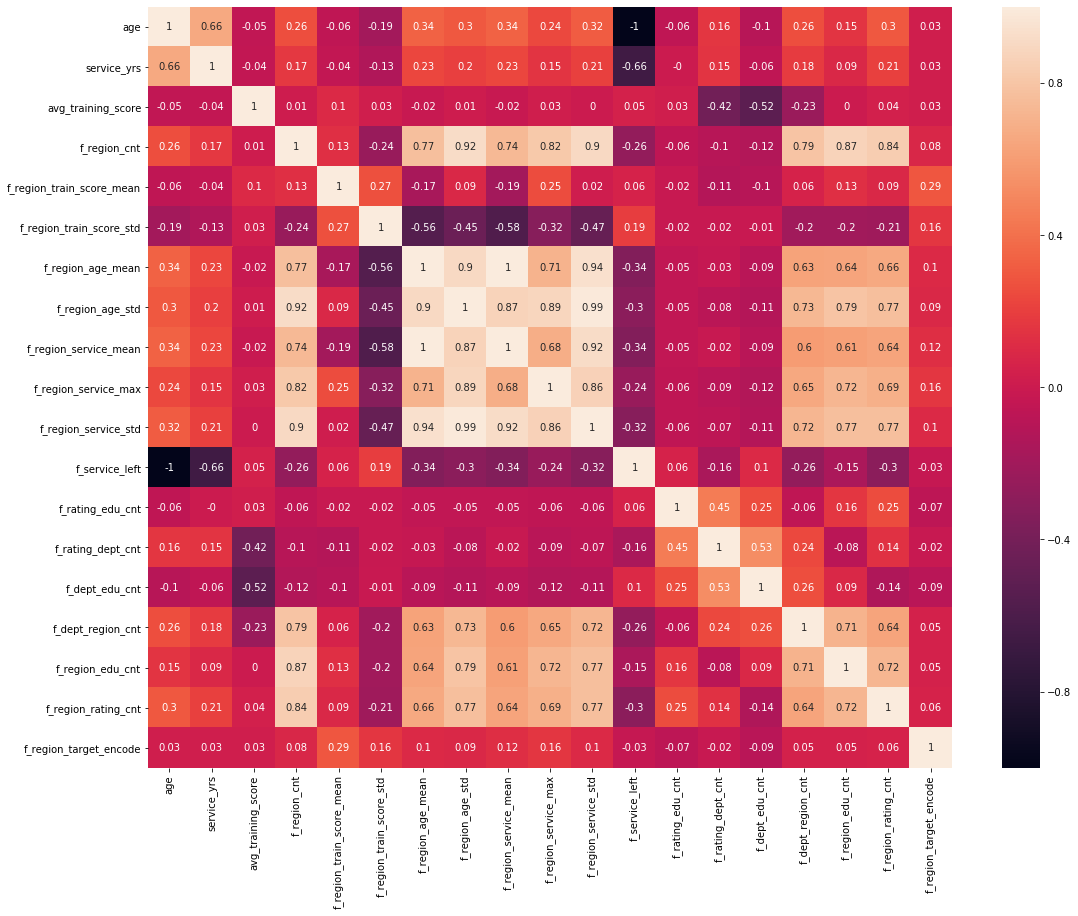

In [12]:
#### heatmap ####
plt.figure(figsize = (18,14))
sns.heatmap(df_train_fe[contineous_vars].corr().round(2), annot=True )
plt.show()

In [13]:
# drop columns highly correlated columns from contineous vars list 
contineous_vars.remove('age'); contineous_vars.remove('f_service_left'); contineous_vars.remove('f_region_cnt');
contineous_vars.remove('f_region_service_std');contineous_vars.remove('f_region_age_std');contineous_vars.remove('f_region_age_mean');
contineous_vars.remove('f_region_target_encode');
len(contineous_vars)

12

In [14]:
#### dropping highly correlated columns ####
df_train_fe = df_train_fe.drop(labels = ['age',  'f_service_left', 'f_region_cnt', 'f_region_target_encode'], axis = 1)
print(df_train_fe.shape)
df_train_fe = df_train_fe.drop(labels = ['f_region_service_std', 'f_region_age_std', 'f_region_age_mean'], axis = 1) 
print(df_train_fe.shape)

(54808, 75)
(54808, 72)


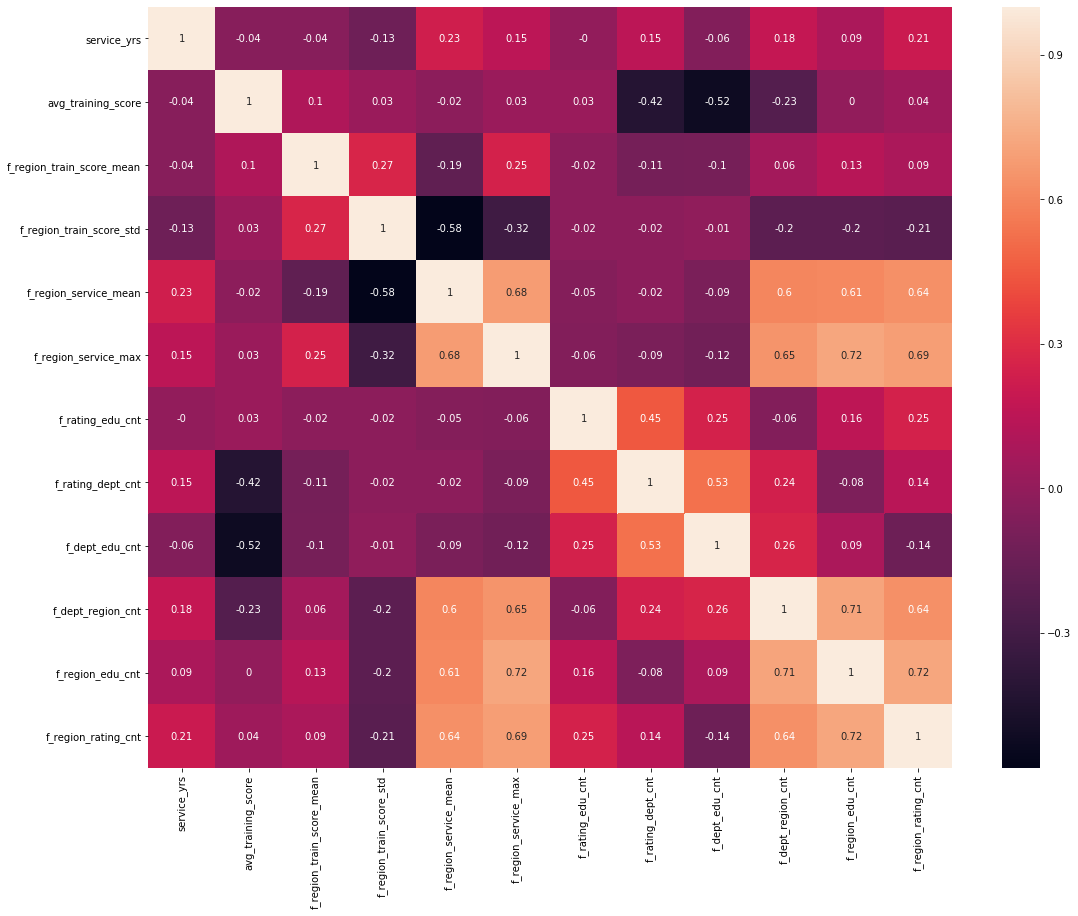

In [15]:
#### heatmap after dropping highly correlated columns ####
plt.figure(figsize = (18,14))
sns.heatmap(df_train_fe[contineous_vars].corr().round(2), annot=True )
plt.show()

Wall time: 54.5 s


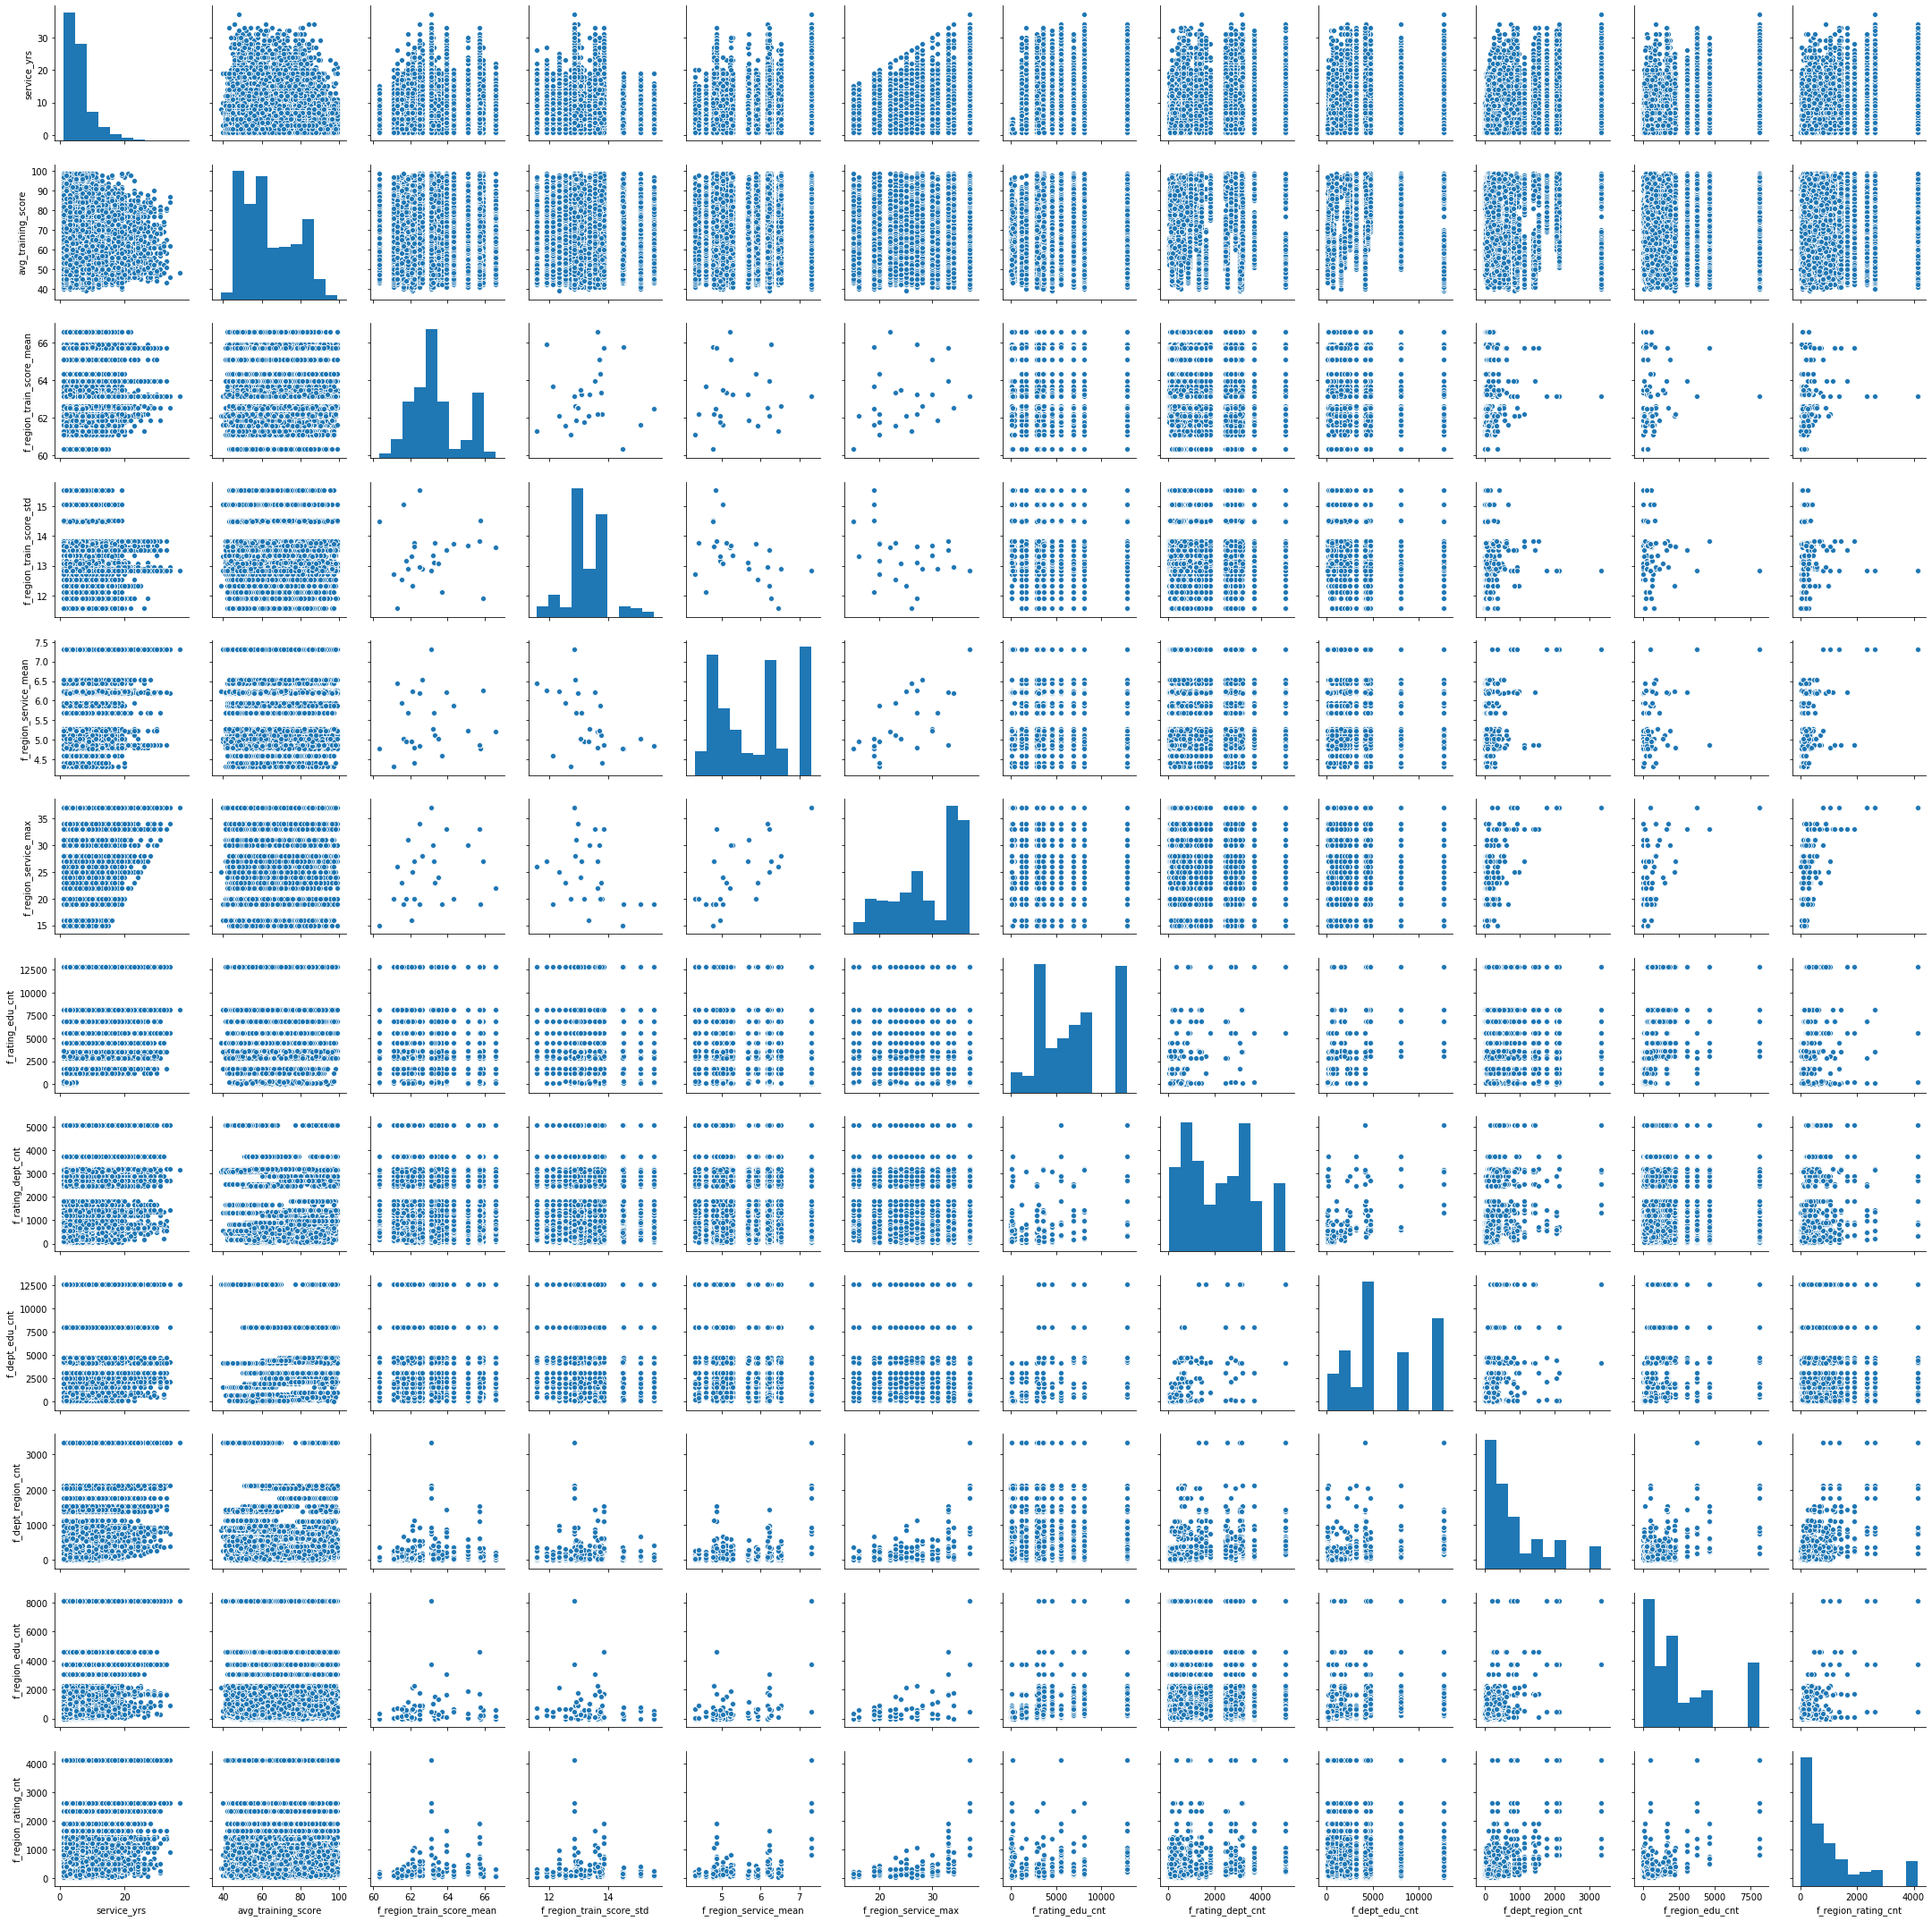

In [16]:
%%time
# pairplot of contineous data
sns.pairplot(df_train_fe[contineous_vars])

#### Observations :
    1. Age and f_service_left features are highly co-related
    2. f_region_cnt and f_region_p features are highly co-related
    3. f_gender_region_cnt and f_edu_region_cnt are highly co-related

#### Chi-Square Statistical Test

In [17]:
#### Statistical Test to know any association or relationship among Categorical variables #### 
test_statistic = []
p_value = []
dof = []
critical_val = []
features_names = []

for i in category_vars: 
        
    observed = pd.crosstab(df_train_fe['promoted'], df_train_fe[i])
    expected = chi2_contingency(observed)
    
    features_names.append(i)
    test_statistic.append(expected[0])
    p_value.append(expected[1])
    dof.append(expected[2])  
    critical = chi2.ppf(0.99, expected[2])
    critical_val.append(critical)

In [18]:
%%time
#### creation of chi-squre Goodness of fit table statistical results dataframe ####
df_chisquare_fs = pd.DataFrame(data = features_names, columns = ['features'])
df_chisquare_fs['critical_val'] = critical_val
df_chisquare_fs['test_statistic'] = test_statistic
df_chisquare_fs['pvalue'] = p_value
df_chisquare_fs['dof'] = dof
cat_cols = list(df_chisquare_fs[(df_chisquare_fs['pvalue'] < 0.01) & (df_chisquare_fs['critical_val'] * 3 < df_chisquare_fs['test_statistic'])]['features'])
print(len(cat_cols))
df_chisquare_fs[(df_chisquare_fs['pvalue'] < 0.01) & (df_chisquare_fs['critical_val'] * 3 < df_chisquare_fs['test_statistic'])]

41
Wall time: 15.6 ms


,features,critical_val,test_statistic,pvalue,dof
1,kpi,6.634897,2689.322055,0.000000e+00,1
2,awarded,6.634897,2098.071921,0.000000e+00,1
3,promoted,6.634897,54795.166435,0.000000e+00,1
5,previous_rating_nan,15.086272,1468.778924,0.000000e+00,5
7,f_age_bins,11.344867,41.804055,4.415231e-09,3
10,ohe_dept_HR,6.634897,26.776027,2.284540e-07,1
15,ohe_dept_Sales & Marketing,6.634897,53.618154,2.434989e-13,1
16,ohe_dept_Technology,6.634897,52.628663,4.029650e-13,1
17,f_dept_cnt,18.475307,145.672669,3.287237e-28,7
18,f_dept_train_score_mean,20.090235,151.426355,9.882497e-29,8


In [19]:
# dropping statistically insignificant categorical features
df_train_fe = df_train_fe.drop(labels = ['f_dept_train_score_std', 'f_dept_age_mean', 'f_dept_age_std', 'f_dept_service_mean', 'f_dept_service_std',
'f_edu_train_score_mean', 'f_edu_train_score_median', 'f_edu_train_score_std', 
'f_edu_age_mean', 'f_edu_age_median', 'f_edu_service_mean', 'f_edu_service_median', 'f_edu_service_max', 
'f_edu_service_std', 'f_edu_cnt', 'f_dept_cnt'], axis = 1)
print(df_train_fe.shape)

df_train_fe = df_train_fe.drop(labels = ['trainings_attended',  'f_service_bins', 'gender_le'], axis = 1)   
print(df_train_fe.shape)
df_train_fe = df_train_fe.drop(labels = ['f_dept_age_min', 'f_dept_age_max', 'f_dept_service_median', 'f_region_service_median',
                                        'f_edu_train_score_min', 'f_edu_train_score_max', 'f_edu_age_max'], axis = 1)
print(df_train_fe.shape)

(54808, 56)
(54808, 53)
(54808, 46)


#### Observations :
    1. trainings_attended, gender_le, f_service_bins features doesn't have strong evidence of Association or significant relationship with recommanded for promoted(target) feature

#### pickling

In [20]:
#### pickling the df_train_eda dataset ####
print(df_train_fe.shape)
joblib.dump(df_train_fe, "df_train_fs.pkl")

(54808, 46)


['df_train_fs.pkl']

In [21]:
# Constant Features 
print(joblib.dump(constant_features, 'fs_1.pkl'))

['fs_1.pkl']


## Kindly comment on the approach for improvement of the model & learning!!!